Title: ROC-AUC Explained
Date: 2019-03-12 10:20
Tags: python
Slug: blog-2

ROC and AUC have long been the words I muddle through because deep down I knew I didn't have a clear understanding of what was happending behind the curves. I just relied on the rule that the higher up the curve (i.e., further away from the diagonal) the better for ROC, and the closer to 1 the better for AUC whenever I encounter a ROC plot. This time I'm going to get to the bottom and get everything clear.  

### Confusion Matrix

To explain ROC, first we need an understanding of the confusion matrix.

For example, suppose we are building a model to classify edible/poisonous mushrooms. We have 1000 mushrooms for which we know each of them is actually edible or not, and use these data to train a model that predicts the edibility based on their features like size, color, and smell. To evaluate the model's performance, we can compare the ground truth to the predictions made. The comparison will look something like this:  

|    Mushrooms         |Actully Edible      |Actually Poisonous |
|-------------------   |--------------      |------------------ |
|Predicted Edible      |482 (TN) |6 (FN) |
|Predicted Poisonous   |84 (FP) |428 (TP)|




Here, the correct predictions are the 482 edible mushrooms that are predicted as edible, and the 428 poisonous mushrooms that are predicted as poisonous. So our accuracy is (482+428)/1000 = 91%. Suppose we call being poisonous a "positive" (more alarming) event, then the correctly identified poisonous mushrooms are True Positives (TP) and the correctly identified edible ones are True Negatives (TN). However, we are more concerned about the errors in this classification. We call the actually edible ones that got misclassified as poisonous the False Positives (FP) and the actually poisonous ones that are wrongfully predicted as edible the False Negatives (FN). In this case, the two types of errors are not equally costly, because the FPs are just a few edible mushroom that got thrown away, but the FNs are truly dangerous because eating one can be fatal.  

### Sensitivity, Specificity, Precision, and F1 Score

Because different mistakes carry different costs (e.g., the FP and FN in the mushroom classfier), sometimes we want to minimize a certain type of error besides maximizing the overall accuracy. There are 4 types of measures that take into consideration of the errors:

- **Sensitivity** (True Positive Rate, **Recall**) = TP/(TP+FN)

- **Specificity** (True Negative Rate) = TN/(FP+TN)

- **Precision** (Positive Predictive Value) = TP/(TP+FP)

- **F1 Score** = 2Precision*Recall/(Precision+Recall)

Here, **sensitivity** is the true positive rate (also called **recall**), because it is the predicted positives over all the actual positives. **Specificity** is the true negative rate, as it is the predicted negatives over all the acutal negatives. **Precision** is the positive predictive value, since it is the true positives over all predicted positives. **F1 score** is the harmonic mean of the precision and recall, taking both FP and FN into account.

The ROC is actually based on sensitivity and specificity.

### Receiver Operating Characteristic Curve (ROC)

Now let's spin up some data to visualize the relationship between TN, TP, FN and FP. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# data generation
def generate_X(mean1, mean2, mean3):
    # generate random normal features for distribution 1
    x1 = pd.DataFrame(np.random.normal(loc=mean1, scale=1, size=1000))
    x2 = pd.DataFrame(np.random.normal(loc=mean2, scale=1, size=1000))
    x3 = pd.DataFrame(np.random.normal(loc=mean3, scale=1, size=1000))
    # generate random normal features for distribution 2
    x4 = pd.DataFrame(np.random.normal(loc=-mean1, scale=1, size=1000))
    x5 = pd.DataFrame(np.random.normal(loc=-mean2, scale=1, size=1000))
    x6 = pd.DataFrame(np.random.normal(loc=-mean3, scale=1, size=1000))
    # concatenate the features 
    X1 = pd.concat([x1, x2, x3], axis=1)
    X2 = pd.concat([x4, x5, x6], axis=1)
    # label the distributions
    X1['label'] = 1
    X2['label'] = 0
    # put the distributions together
    X = pd.concat([X1, X2], axis=0)
    X.columns= ['x1','x2','x3','label']
    # calculate the probability of being in label 1 using the logit link
    proba_y = 1/(1+np.exp(-(X.x1+X.x2+X.x3)))
    X['proba'] = proba_y
    # plot the probability distribution
    X[X.label==1]['proba'].hist(alpha=0.5, label='1')
    X[X.label==0]['proba'].hist(alpha=0.5, label='0')
    plt.title('Distribution of Prob(label=1)')
    plt.xlabel('Predicted Prob(label=1)')
    plt.ylabel('Frequency')
    plt.legend()
    return X

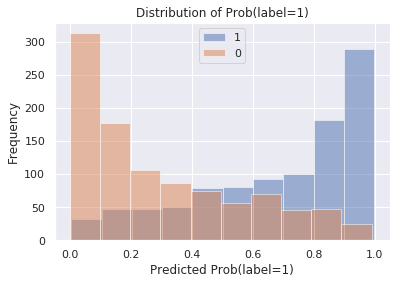

In [3]:
X1 = generate_X(0.3, 0.4, 0.5)

We first generate two distributions using linear combination of random normal features whose means are symmetric to each other with respect to x=0. The data points in the first distribution are then assigned label value of 1, and the second 0. These are the true labels of the data points. Then we calculate the probability of each data point being classified as 1 or 0 using a logistic link. Plotting these probabilities, we can see that the first distribution (the Blue one) has a much higher frequency of being classified as 1, while the second distribution (the Orange one) has a much higher tendency of being classified as 0. The two distributions look quite separated, which is exactly what we want here because this indicates that the data can be separated well by a logistic classifier. We can then fit it into a logistic regression model to get the predicted probabilities and predicted labels needed to calculate TP, FP, TN, and FN.   

In [4]:
# prepare for training
def label_data(X):
    X_train = X[['x1', 'x2', 'x3']]
    y_train = X['label']
    return X_train, y_train

In [5]:
X1_train, y1_train = label_data(X1)

In [6]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def logreg(X_train, y_train, X):
    logreg = LogisticRegression(solver='lbfgs')
    logreg.fit(X_train, y_train)
    X['predict_proba'] = logreg.predict_proba(X_train)[:,1]
    X['preds'] = logreg.predict(X_train)

In [7]:
logreg(X1_train, y1_train, X1)

Now we plot the predicted probablities:

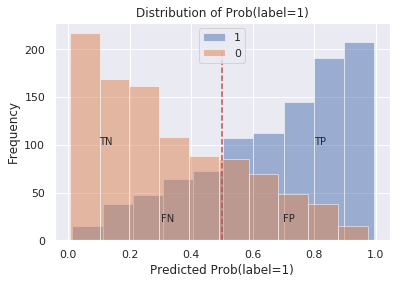

In [8]:
plt.vlines(x=0.5, ymin=0,ymax=200,color='r',linestyle='--')
X1[X1.label==1]['predict_proba'].hist(alpha=0.5, label='1')
X1[X1.label==0]['predict_proba'].hist(alpha=0.5, label='0')
plt.title('Distribution of Prob(label=1)')
plt.xlabel('Predicted Prob(label=1)')
plt.ylabel('Frequency')
plt.legend()
plt.text(0.8, 100, 'TP')
plt.text(0.7, 20, 'FP')
plt.text(0.1, 100, 'TN')
plt.text(0.3, 20, 'FN');

We can see that the model-predicted probabilites are similar to the probabilities we calculated using logit link when generating the data. Now, by default the model classifies any data point with a predicted probability larger than 0.5 as being in class 1, and else class 0. This can be visualized in the plot above, where the red dotted line is x=0.5. The right hand side of the blue distribution got correctly classifed as label 1, so they are the TPs. Similarly, the left hand side of the orange distribution got correctly classifed as label 0, thus the TNs. The right tail of the orange distribution are the ones that are actually label 0 but got predicted to be 1 because of their high probabilities; they are therefore the FPs. In the same fashion, the left tail of the blue distribution are the FNs.  

We can obtain the TP, TN, FP and FN by calling confusion matrix directly from scikit learn modules to save some effors: 

In [9]:
tn, fp, fn, tp = confusion_matrix(X1.label, X1.preds).ravel()
print(f'tn={tn}, fp={fp}, fn={fn}, tp={tp}')

tn=759, fp=241, fn=232, tp=768


Because ROC is based on sensitivy and specificity, we will calculate them as well:

In [10]:
sens = tp/(tp+fn)
spec = tn/(fp+tn)
print(f'sens={sens}, spec={spec}')

sens=0.768, spec=0.759


Now we can finally come to explaining ROC. The ROC is the curve we will get if we plot 1-specificity on the x-axis and sensitivity on the y-axis for every pair of sensitivity/specificity values we obtain by moving the cut-off point for classifying 0/1 on the predicted probablities from x=0.0 to x=1.0. For example, now we are using cut-off as x=0.5, and we obtain sensitivity=0.77 and specificity=0.76. If we plot it, we will get a single point: 

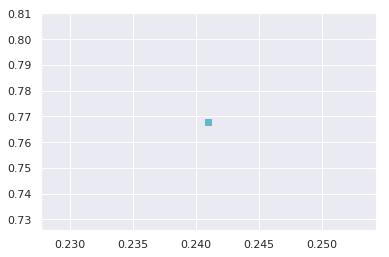

In [11]:
plt.plot(1-spec, sens, 'cs');

If we move the cut-off to x=0.8, for example, which means data points with a predicted probability equal to or higher than 0.8 of being in the label 1 class got classified as label 1, else label 0, then we will get a set of different classification results (in terms of TP, TN, FP and FN):

In [12]:
preds = np.where(X1.predict_proba >= 0.8, 1, 0)
tn1, fp1, fn1, tp1 = confusion_matrix(X1.label, preds).ravel()
sens1 = tp1/(tp1+fn1)
spec1 = tn1/(tn1+fp1)
print(f'tn={tn1}, fp={fp1}, fn={fn1}, tp={tp1}')
print(f'sens={sens1}, spec={spec1}')

tn=956, fp=44, fn=602, tp=398
sens=0.398, spec=0.956


Now we can plot the two points together:

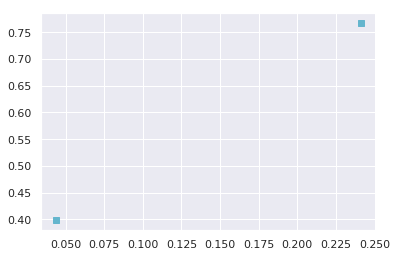

In [13]:
plt.plot(1-spec, sens, 'cs')
plt.plot(1-spec1, sens1, 'cs');

If we keep doing this for every possible cut-off value (i.e., ranging from x=0.0 to x=1.0), we will obtain a lot of points and when they connect and form a curve, we have the ROC. It indicates how well the two distributions are separated by our model. If the two distributions are very well separated (as there are very few FPs or FNs), the ROC will be higher close to the upper left corner, like this: 

In [14]:
# define a function to plot ROC
def plot_roc(X, y):
    sens_list = []
    spec_list = []
    for cutoff in np.linspace(0,1,num=100):
        X[f'preds_{cutoff}'] = np.where(X.predict_proba >= cutoff, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y, X[f'preds_{cutoff}']).ravel()
        sens = tp/(tp+fn)
        spec = tn/(tn+fp)
        sens_list.append(sens)
        spec_list.append(spec)

    roc = {'sens':sens_list, 'spec':spec_list}
    roc = pd.DataFrame(roc)
    plt.plot(1-roc.spec, roc.sens, 'cs')

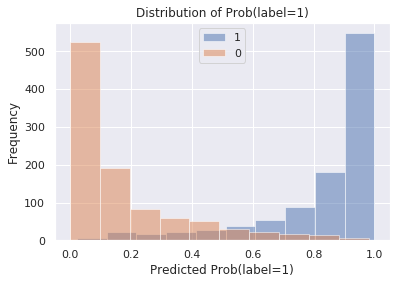

In [15]:
# generate two distributions that are far away from each other so they 
# are easily separable 
X2 = generate_X(0.7, 0.8, 0.9)

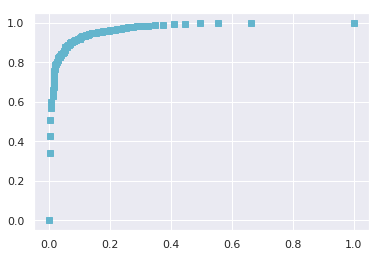

In [16]:
# plot the ROC
X2_train, y2_train = label_data(X2)
logreg(X2_train, y2_train, X2)
plot_roc(X2, y2_train)

A ROC like this means the model is doing a good job separating the classes and the predictions are fairly accurate.

If the model doesn't do a good job separating the two classes (i.e., a lot of FPs and FNs), the ROC will be close to the diagonal, like this:

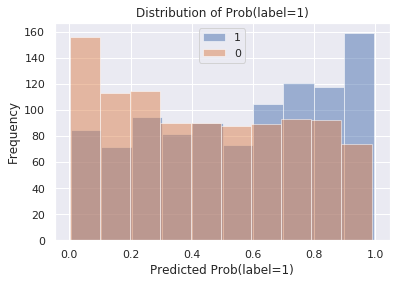

In [17]:
# generate two distributions that are highly overlapped so they 
# are difficult to separate 
X3 = generate_X(0.05, 0.1, 0.15)

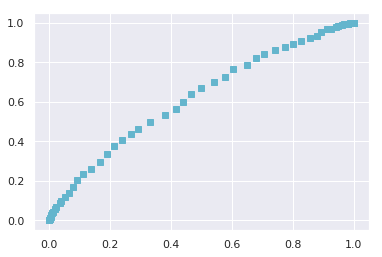

In [18]:
# plot the ROC
X3_train, y3_train = label_data(X3)
logreg(X3_train, y3_train, X3)
plot_roc(X3, y3_train)

A ROC close to the diagonal means that the model is performing poorly at separating the two classes and its predictions are almost like random guesses.

A usual ROC generally looks like this:

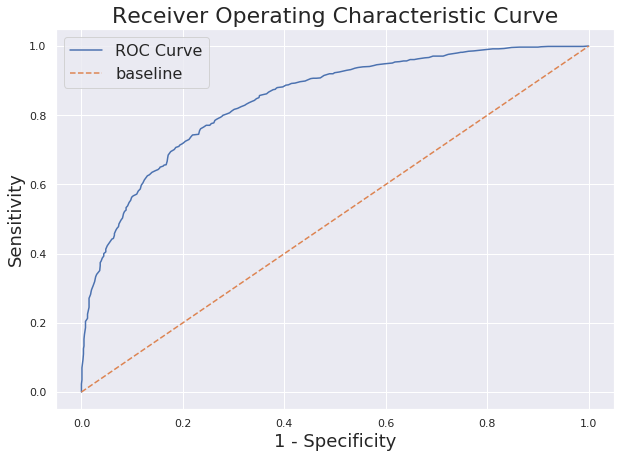

In [19]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(X1, 'label', 'predict_proba', prob) for prob in thresholds]
fpr_values = [FPR(X1, 'label', 'predict_proba', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Area Under Curve (AUC)

Now we are left with the final concept, AUC, which is the area under the ROC. It is a very straight forward measure of how well a model performs, because the higher up the ROC to the upper left corner, the larger the AUC will be. We want our model's AUC to be as large as possible, ranging from 0.5 to 1.0 where 0.5 is the worst model possible and 1.0 is a perfect classifier.

We can obtain the AUC directly by calling scikit learn module:

In [20]:
from sklearn.metrics import roc_auc_score
print(f'AUC={roc_auc_score(X1.label, X1.preds)}')

AUC=0.7635


### AOC

Finally, per Max's request, I'm also going to show what is AOC (Area Over Curve). And that literally is:

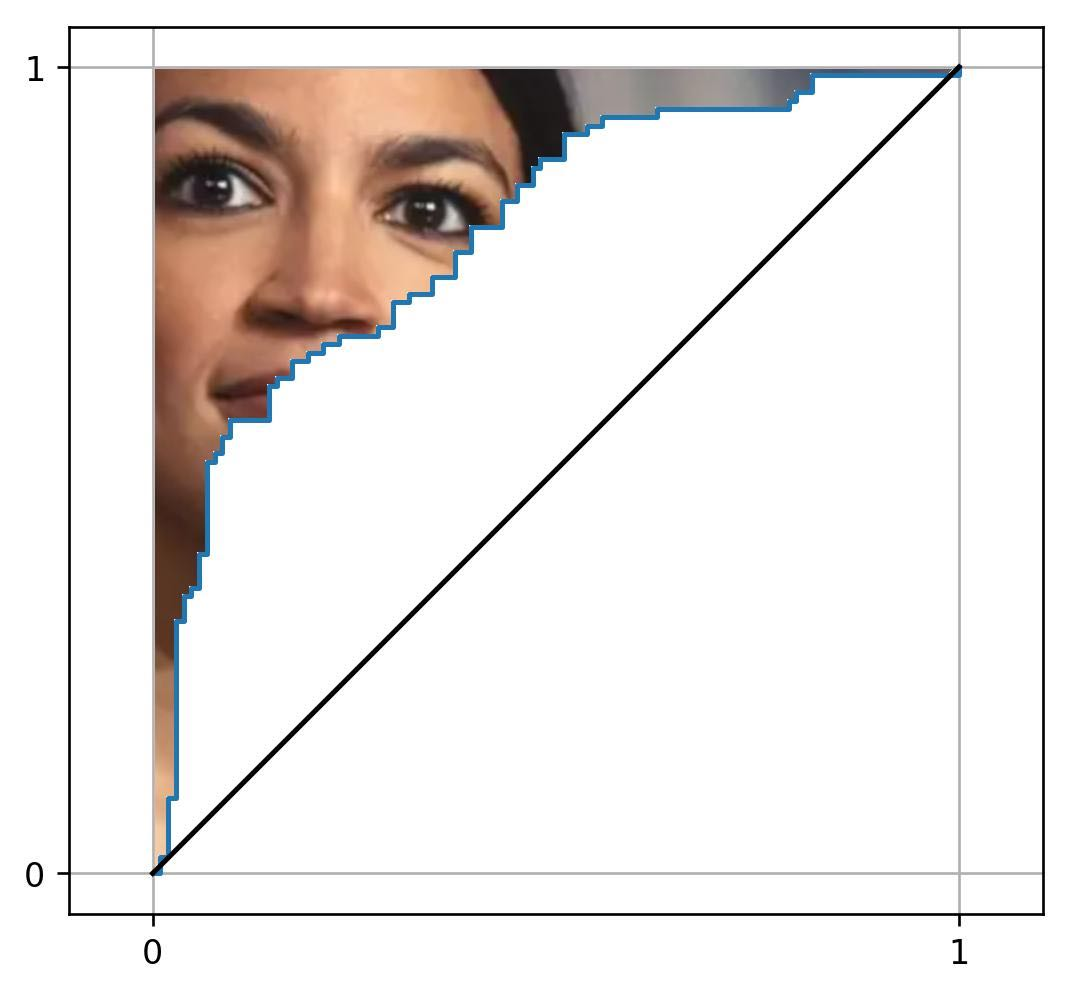

In [27]:
from IPython.display import Image
# from IPython.core.display import HTML
Image('AOC.jpg', width=100, height=100)

Writing this post tremendously helped me understand the mechanism behind ROC. Hope it's helpful to you too.